In [802]:
%matplotlib inline
from sklearn import datasets
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df["target_name"]=iris['target_names'][iris_df['target']] 
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 7.1 Cluster the data using the KMeans implementation of scikit-learn!

* Resource: <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html>
* Measure the runtime for training the model!
* Experiment with different number of clusters! What are your observations!
* Plot the results!

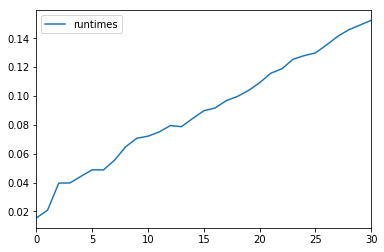

In [803]:
import time as t
X = iris_df[["sepal length (cm)","sepal width (cm)","petal length (cm)","petal width (cm)"]]
runtimes = []

for i in range(1,32):
    estimator = KMeans(n_clusters=i)
    start = t.time()
    estimator.fit(X)
    runtime = t.time()-start
    runtimes.append(runtime)
    #print("Runtime for " + str(i) + " cluster is " + str(runtime))
    
#layout = {'8': [float(t[0]),float(t[2])],
#          '16': [float(t[1]),float(t[3])]}
plot_df = pd.DataFrame({'runtimes': runtimes})
plot_df
plot_df.plot()

## 7.2 MLlib Clustering

* MLLib KMeans Example: 
    * <https://spark.apache.org/docs/latest/ml-clustering.html>
    * <https://spark.apache.org/docs/latest/api/python/>
    * <https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator>
* Run KMeans on the provided Iris dataset!

In [804]:
# Initialize PySpark
import os, sys
os.environ["JAVA_HOME"]="/lrz/sys/compilers/java/jdk1.8.0_112"
APP_NAME = "PySpark Lecture"
SPARK_MASTER="local[1]"
import pyspark
import pyspark.sql
from pyspark.sql import Row
conf=pyspark.SparkConf()
conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySpark Lecture, master=local[1]) created by __init__ at <ipython-input-3-79f80fc5169f>:11 

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

spark_df = spark.createDataFrame(iris_df)

assembler = VectorAssembler(
    inputCols=["sepal length (cm)", "sepal width (cm)", "petal length (cm)","petal width (cm)"],
    outputCol="features")

output = assembler.transform(spark_df)
output = output.select("features", "target")

kmeans = KMeans().setK(3).setSeed(42)
model = kmeans.fit(output)

* Validate the quality of the model using the sum of the squared error for each point! Use the ClusterEvaluator of Spark MLlib!

In [ ]:

evaluator = ClusteringEvaluator(predictionCol='target',distanceMeasure='squaredEuclidean')
a = evaluator.evaluate(output)
a


## 7.3 Manual KMeans Clustering

Implement a KMeans Model using Spark MapReduce (Do Not use MLlib version!)!

In [815]:
import random
from scipy.spatial import distance
def x(a,b):
    sum = 0
    for i in range(0,len(a)-1):
        print(i)
        #sum = sum + ((b[i]-a[i])**2)
    return sum


iter = 100
cluster = 3
seed = 42
clusterList = []

test = 0
clusterList = iris_df.sample(cluster)
c1 = tuple(clusterList.iloc[0])[0:-2]
c2 = tuple(clusterList.iloc[1])[0:-2]
c3 = tuple(clusterList.iloc[2])[0:-2]

for i in range(0,iter):


    y = (1,2,3,4)

    def hack(a):
        x0 = 0
        x1 = 0
        x2 = 0
        x3 = 0
        l = list(a)
        mult = 1/len(l)
        for x in l:
            x0 += x[0]
            x1 += x[1]
            x2 += x[2]
            x3 += x[3]
        return (mult*x0,mult*x1,mult*x2,mult*x3)


    all = spark.createDataFrame(iris_df).rdd
    a = all.map(lambda x: (x[0:4]))

    a = a.map(lambda x: (x,(distance.euclidean(tuple(x), c1),distance.euclidean(tuple(x), c2),distance.euclidean(tuple(x), c3))))
    a = a.map(lambda x: (x[1].index(min(x[1])),x[0]))
    a.filter(lambda x: x[0] == 0).collect()
    test = a.groupByKey(1).map(lambda x : (x[0], hack(x[1])))
    test = test.toDF().toPandas()
    for i in [1,2,3]:
        t  = test[i-1:i]['_1'].values[0]
        v  = test[i-1:i]['_2'].values[0]
        tp = (v[0],v[1],v[2],v[3])
        print("T: "+ str(t) + " val: " + str(tp) )
        if t == 0:
            change1 = distance.euclidean(c1,tp)
            c1 = tp
        if t == 1:
            change2 = distance.euclidean(c2,tp)
            c2 = tp
        if t == 2:
            change3 = distance.euclidean(c3,tp)
            c3 = tp
    #print("dis1: " + str(change1) + " dis2: " + str(change2) + "dis3: "+str(change3) +"\n")
    if change1 == change2 == change3:
        break

            

#x = test[0:1]['_2'].values[0]
#x?


T: 2 val: (5.005999999999999, 3.428000000000001, 1.4620000000000002, 0.2459999999999999)
T: 1 val: (6.404597701149422, 2.9333333333333336, 5.0873563218390805, 1.7505747126436786)
T: 0 val: (5.307692307692309, 2.4615384615384612, 3.6923076923076925, 1.176923076923077)
T: 2 val: (5.005999999999999, 3.428000000000001, 1.4620000000000002, 0.2459999999999999)
T: 1 val: (6.532876712328765, 2.964383561643836, 5.263013698630138, 1.8452054794520545)
T: 0 val: (5.529629629629628, 2.622222222222222, 3.9407407407407407, 1.2185185185185186)
T: 2 val: (5.005999999999999, 3.428000000000001, 1.4620000000000002, 0.2459999999999999)
T: 1 val: (6.5772727272727245, 2.990909090909091, 5.3484848484848495, 1.895454545454545)
T: 0 val: (5.649999999999999, 2.641176470588235, 4.047058823529412, 1.25)
T: 2 val: (5.005999999999999, 3.428000000000001, 1.4620000000000002, 0.2459999999999999)
T: 1 val: (6.601587301587299, 2.9857142857142853, 5.384126984126984, 1.9158730158730153)
T: 0 val: (5.683783783783783, 2.6783

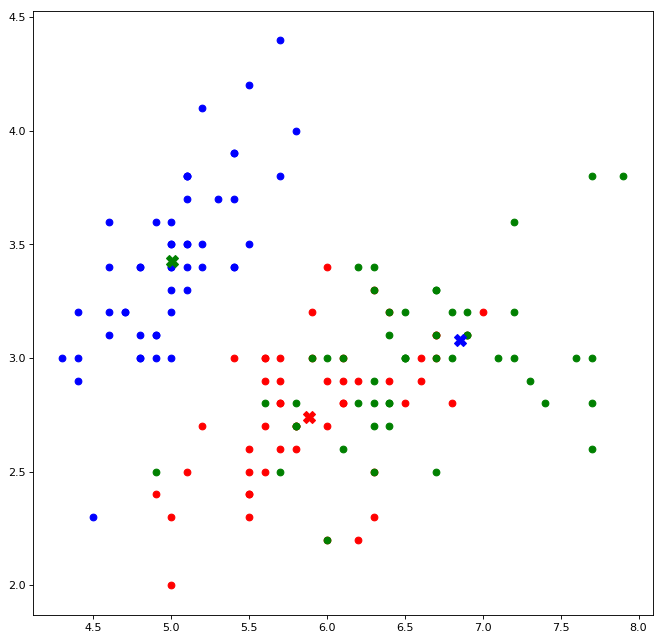

In [816]:
#p.plot(2,2,'ro') 
from matplotlib.pyplot import figure
f = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

tmp_df =  iris_df[iris_df['target']==0]
plt.scatter(tmp_df[["sepal length (cm)"]],y = tmp_df[["sepal width (cm)"]],figure=f,c="blue")

tmp_df =  iris_df[iris_df['target']==1]
plt.scatter(tmp_df[["sepal length (cm)"]],y = tmp_df[["sepal width (cm)"]],figure=f,c="Red")

tmp_df =  iris_df[iris_df['target']==2]
plt.scatter(tmp_df[["sepal length (cm)"]],y = tmp_df[["sepal width (cm)"]],figure=f,c="Green")

plt.plot(c1[0], c1[1], 'go',marker='X',markersize=10,c="red")
plt.plot(c2[0], c2[1], 'go',marker='X',markersize=10,c="blue")
plt.plot(c3[0], c3[1], 'go',marker='X',markersize=10,c="green")

